# Analisis Anomali Data Transaksi Bank

Analisis ini bertujuan untuk mengidentifikasi berbagai jenis anomali dalam data transaksi bank yang dapat mengindikasikan:
- Fraud atau transaksi mencurigakan
- Error dalam sistem
- Pola transaksi yang tidak wajar
- Outlier statistik

In [1]:
# Import library yang diperlukan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set style untuk plot
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [2]:
# Load data transaksi bank
df = pd.read_csv('bank_transactions_data_2.csv')

# Tampilkan informasi umum tentang dataset
print("=== INFORMASI DATASET ===")
print(f"Jumlah baris: {df.shape[0]}")
print(f"Jumlah kolom: {df.shape[1]}")
print(f"\nNama kolom: {list(df.columns)}")
print(f"\nTipe data:")
print(df.dtypes)
print(f"\nInfo dataset:")
print(df.info())

=== INFORMASI DATASET ===
Jumlah baris: 2512
Jumlah kolom: 16

Nama kolom: ['TransactionID', 'AccountID', 'TransactionAmount', 'TransactionDate', 'TransactionType', 'Location', 'DeviceID', 'IP Address', 'MerchantID', 'Channel', 'CustomerAge', 'CustomerOccupation', 'TransactionDuration', 'LoginAttempts', 'AccountBalance', 'PreviousTransactionDate']

Tipe data:
TransactionID               object
AccountID                   object
TransactionAmount          float64
TransactionDate             object
TransactionType             object
Location                    object
DeviceID                    object
IP Address                  object
MerchantID                  object
Channel                     object
CustomerAge                  int64
CustomerOccupation          object
TransactionDuration          int64
LoginAttempts                int64
AccountBalance             float64
PreviousTransactionDate     object
dtype: object

Info dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex:

In [3]:
# Lihat sample data
print("=== SAMPLE DATA (5 baris pertama) ===")
print(df.head())
print("\n=== SAMPLE DATA (5 baris terakhir) ===")
print(df.tail())

=== SAMPLE DATA (5 baris pertama) ===
  TransactionID AccountID  TransactionAmount      TransactionDate  \
0      TX000001   AC00128              14.09  2023-04-11 16:29:14   
1      TX000002   AC00455             376.24  2023-06-27 16:44:19   
2      TX000003   AC00019             126.29  2023-07-10 18:16:08   
3      TX000004   AC00070             184.50  2023-05-05 16:32:11   
4      TX000005   AC00411              13.45  2023-10-16 17:51:24   

  TransactionType   Location DeviceID      IP Address MerchantID Channel  \
0           Debit  San Diego  D000380  162.198.218.92       M015     ATM   
1           Debit    Houston  D000051     13.149.61.4       M052     ATM   
2           Debit       Mesa  D000235  215.97.143.157       M009  Online   
3           Debit    Raleigh  D000187  200.13.225.150       M002  Online   
4          Credit    Atlanta  D000308    65.164.3.100       M091  Online   

   CustomerAge CustomerOccupation  TransactionDuration  LoginAttempts  \
0           70   

In [4]:
# Cek missing values dan duplikasi
print("=== ANALISIS KUALITAS DATA ===")
print("Missing values per kolom:")
print(df.isnull().sum())
print(f"\nPersentase missing values:")
print((df.isnull().sum() / len(df)) * 100)
print(f"\nJumlah data duplikat: {df.duplicated().sum()}")

# Cek nilai unik untuk kolom kategoris
print(f"\n=== NILAI UNIK KOLOM KATEGORIS ===")
for col in df.select_dtypes(include=['object']).columns:
    print(f"\n{col}: {df[col].nunique()} nilai unik")
    print(f"Nilai: {df[col].unique()[:10]}...")  # Tampilkan 10 nilai pertama

=== ANALISIS KUALITAS DATA ===
Missing values per kolom:
TransactionID              0
AccountID                  0
TransactionAmount          0
TransactionDate            0
TransactionType            0
Location                   0
DeviceID                   0
IP Address                 0
MerchantID                 0
Channel                    0
CustomerAge                0
CustomerOccupation         0
TransactionDuration        0
LoginAttempts              0
AccountBalance             0
PreviousTransactionDate    0
dtype: int64

Persentase missing values:
TransactionID              0.0
AccountID                  0.0
TransactionAmount          0.0
TransactionDate            0.0
TransactionType            0.0
Location                   0.0
DeviceID                   0.0
IP Address                 0.0
MerchantID                 0.0
Channel                    0.0
CustomerAge                0.0
CustomerOccupation         0.0
TransactionDuration        0.0
LoginAttempts              0.0
Acco

## 1. Analisis Statistik Deskriptif

In [5]:
# Analisis statistik deskriptif untuk kolom numerik
print("=== STATISTIK DESKRIPTIF ===")
numeric_cols = df.select_dtypes(include=[np.number]).columns
print(f"Kolom numerik: {list(numeric_cols)}")
print("\nStatistik deskriptif:")
print(df[numeric_cols].describe())

# Identifikasi kolom yang mungkin mengandung nilai transaksi
amount_cols = [col for col in df.columns if any(keyword in col.lower() 
               for keyword in ['amount', 'value', 'price', 'cost', 'fee', 'balance', 'sum'])]
print(f"\nKolom yang kemungkinan berisi nilai transaksi: {amount_cols}")

# Jika tidak ada kolom yang jelas mengandung amount, tampilkan semua kolom numerik
if not amount_cols:
    amount_cols = numeric_cols.tolist()
    print(f"Menggunakan semua kolom numerik untuk analisis: {amount_cols}")

=== STATISTIK DESKRIPTIF ===
Kolom numerik: ['TransactionAmount', 'CustomerAge', 'TransactionDuration', 'LoginAttempts', 'AccountBalance']

Statistik deskriptif:
       TransactionAmount  CustomerAge  TransactionDuration  LoginAttempts  \
count        2512.000000  2512.000000          2512.000000    2512.000000   
mean          297.593778    44.673965           119.643312       1.124602   
std           291.946243    17.792198            69.963757       0.602662   
min             0.260000    18.000000            10.000000       1.000000   
25%            81.885000    27.000000            63.000000       1.000000   
50%           211.140000    45.000000           112.500000       1.000000   
75%           414.527500    59.000000           161.000000       1.000000   
max          1919.110000    80.000000           300.000000       5.000000   

       AccountBalance  
count     2512.000000  
mean      5114.302966  
std       3900.942499  
min        101.250000  
25%       1504.370000  


In [6]:
# Fungsi untuk mendeteksi outlier menggunakan IQR
def detect_outliers_iqr(data, column):
    """Deteksi outlier menggunakan metode IQR"""
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

# Fungsi untuk mendeteksi outlier menggunakan Z-Score
def detect_outliers_zscore(data, column, threshold=3):
    """Deteksi outlier menggunakan Z-Score"""
    z_scores = np.abs(stats.zscore(data[column]))
    outliers = data[z_scores > threshold]
    return outliers, z_scores

print("=== DETEKSI OUTLIER ===")
for col in amount_cols:
    print(f"\n--- Analisis Outlier untuk {col} ---")
    
    # IQR Method
    outliers_iqr, lower_bound, upper_bound = detect_outliers_iqr(df, col)
    print(f"IQR Method - Batas bawah: {lower_bound:.2f}, Batas atas: {upper_bound:.2f}")
    print(f"Jumlah outlier (IQR): {len(outliers_iqr)} ({len(outliers_iqr)/len(df)*100:.2f}%)")
    
    # Z-Score Method
    outliers_zscore, z_scores = detect_outliers_zscore(df, col)
    print(f"Z-Score Method - Jumlah outlier (Z>3): {len(outliers_zscore)} ({len(outliers_zscore)/len(df)*100:.2f}%)")
    
    if len(outliers_iqr) > 0:
        print(f"Outlier tertinggi (IQR): {outliers_iqr[col].max():.2f}")
        print(f"Outlier terendah (IQR): {outliers_iqr[col].min():.2f}")

=== DETEKSI OUTLIER ===

--- Analisis Outlier untuk TransactionAmount ---
IQR Method - Batas bawah: -417.08, Batas atas: 913.49
Jumlah outlier (IQR): 113 (4.50%)
Z-Score Method - Jumlah outlier (Z>3): 48 (1.91%)
Outlier tertinggi (IQR): 1919.11
Outlier terendah (IQR): 917.81

--- Analisis Outlier untuk AccountBalance ---
IQR Method - Batas bawah: -7757.30, Batas atas: 16940.49
Jumlah outlier (IQR): 0 (0.00%)
Z-Score Method - Jumlah outlier (Z>3): 0 (0.00%)


## 2. Deteksi Anomali Transaksi Spesifik

In [7]:
# 1. Transaksi dengan jumlah sangat tinggi (Top 1% transaksi)
print("=== ANOMALI 1: TRANSAKSI NILAI TINGGI ===")
top_1_percent_threshold = df['TransactionAmount'].quantile(0.99)
high_value_transactions = df[df['TransactionAmount'] >= top_1_percent_threshold]

print(f"Threshold top 1%: ${top_1_percent_threshold:.2f}")
print(f"Jumlah transaksi high-value: {len(high_value_transactions)}")
print(f"Rata-rata nilai transaksi high-value: ${high_value_transactions['TransactionAmount'].mean():.2f}")
print(f"Median nilai transaksi high-value: ${high_value_transactions['TransactionAmount'].median():.2f}")

print("\nSample transaksi high-value:")
print(high_value_transactions[['TransactionAmount', 'CustomerAge', 'AccountBalance']].head())

# 2. Transaksi dengan jumlah sangat rendah (potensi micro-laundering)
print("\n=== ANOMALI 2: TRANSAKSI NILAI SANGAT RENDAH ===")
bottom_1_percent_threshold = df['TransactionAmount'].quantile(0.01)
very_low_transactions = df[df['TransactionAmount'] <= bottom_1_percent_threshold]

print(f"Threshold bottom 1%: ${bottom_1_percent_threshold:.2f}")
print(f"Jumlah transaksi very-low: {len(very_low_transactions)}")
print(f"Rata-rata nilai transaksi very-low: ${very_low_transactions['TransactionAmount'].mean():.2f}")

print("\nSample transaksi very-low:")
print(very_low_transactions[['TransactionAmount', 'CustomerAge', 'AccountBalance']].head())

=== ANOMALI 1: TRANSAKSI NILAI TINGGI ===
Threshold top 1%: $1360.60
Jumlah transaksi high-value: 26
Rata-rata nilai transaksi high-value: $1530.51
Median nilai transaksi high-value: $1473.76

Sample transaksi high-value:
     TransactionAmount  CustomerAge  AccountBalance
176            1362.55           29         2429.68
190            1422.55           79         5674.32
340            1830.00           55         2235.70
375            1392.54           41        13347.69
475            1431.30           18         1058.13

=== ANOMALI 2: TRANSAKSI NILAI SANGAT RENDAH ===
Threshold bottom 1%: $4.40
Jumlah transaksi very-low: 26
Rata-rata nilai transaksi very-low: $2.31

Sample transaksi very-low:
     TransactionAmount  CustomerAge  AccountBalance
115               2.50           47        12145.27
195               3.30           50        11385.37
490               0.99           45         4317.85
504               3.42           43        14180.21
556               2.03       

In [8]:
# 3. Analisis anomali berdasarkan durasi transaksi
print("=== ANOMALI 3: DURASI TRANSAKSI ABNORMAL ===")

# Transaksi yang terlalu cepat (potensi otomatis/bot)
fast_threshold = df['TransactionDuration'].quantile(0.05)
fast_transactions = df[df['TransactionDuration'] <= fast_threshold]

# Transaksi yang terlalu lama (potensi masalah teknis)
slow_threshold = df['TransactionDuration'].quantile(0.95)
slow_transactions = df[df['TransactionDuration'] >= slow_threshold]

print(f"Durasi transaksi sangat cepat (<= {fast_threshold} detik): {len(fast_transactions)} transaksi")
print(f"Durasi transaksi sangat lambat (>= {slow_threshold} detik): {len(slow_transactions)} transaksi")

print(f"\nStatistik durasi transaksi cepat:")
print(f"Min: {fast_transactions['TransactionDuration'].min()}, Max: {fast_transactions['TransactionDuration'].max()}")
print(f"Rata-rata nilai transaksi cepat: ${fast_transactions['TransactionAmount'].mean():.2f}")

print(f"\nStatistik durasi transaksi lambat:")
print(f"Min: {slow_transactions['TransactionDuration'].min()}, Max: {slow_transactions['TransactionDuration'].max()}")
print(f"Rata-rata nilai transaksi lambat: ${slow_transactions['TransactionAmount'].mean():.2f}")

# 4. Analisis anomali berdasarkan login attempts
print("\n=== ANOMALI 4: LOGIN ATTEMPTS ABNORMAL ===")
multiple_login_attempts = df[df['LoginAttempts'] > 1]
excessive_login_attempts = df[df['LoginAttempts'] >= 3]

print(f"Transaksi dengan multiple login attempts (>1): {len(multiple_login_attempts)}")
print(f"Transaksi dengan excessive login attempts (>=3): {len(excessive_login_attempts)}")

if len(excessive_login_attempts) > 0:
    print(f"Distribusi login attempts yang tinggi:")
    print(excessive_login_attempts['LoginAttempts'].value_counts().sort_index())
    print(f"Rata-rata nilai transaksi dengan excessive login: ${excessive_login_attempts['TransactionAmount'].mean():.2f}")

=== ANOMALI 3: DURASI TRANSAKSI ABNORMAL ===
Durasi transaksi sangat cepat (<= 24.0 detik): 131 transaksi
Durasi transaksi sangat lambat (>= 265.0 detik): 128 transaksi

Statistik durasi transaksi cepat:
Min: 10, Max: 24
Rata-rata nilai transaksi cepat: $255.34

Statistik durasi transaksi lambat:
Min: 265, Max: 300
Rata-rata nilai transaksi lambat: $263.70

=== ANOMALI 4: LOGIN ATTEMPTS ABNORMAL ===
Transaksi dengan multiple login attempts (>1): 122
Transaksi dengan excessive login attempts (>=3): 95
Distribusi login attempts yang tinggi:
LoginAttempts
3    31
4    32
5    32
Name: count, dtype: int64
Rata-rata nilai transaksi dengan excessive login: $276.32


In [9]:
# 5. Analisis anomali berdasarkan rasio transaksi vs saldo
print("=== ANOMALI 5: RASIO TRANSAKSI VS SALDO ABNORMAL ===")

# Hitung rasio transaksi terhadap saldo
df['TransactionToBalanceRatio'] = df['TransactionAmount'] / df['AccountBalance']

# Transaksi yang nilainya sangat besar dibanding saldo (potensi risky)
high_ratio_threshold = df['TransactionToBalanceRatio'].quantile(0.95)
high_ratio_transactions = df[df['TransactionToBalanceRatio'] >= high_ratio_threshold]

print(f"Threshold rasio tinggi (95th percentile): {high_ratio_threshold:.4f}")
print(f"Transaksi dengan rasio tinggi: {len(high_ratio_transactions)}")
print(f"Rata-rata rasio pada transaksi high-ratio: {high_ratio_transactions['TransactionToBalanceRatio'].mean():.4f}")

# Cari transaksi dengan rasio > 50% dari saldo
very_high_ratio = df[df['TransactionToBalanceRatio'] > 0.5]
print(f"\nTransaksi dengan nilai > 50% saldo: {len(very_high_ratio)}")

if len(very_high_ratio) > 0:
    print("Sample transaksi dengan rasio sangat tinggi:")
    print(very_high_ratio[['TransactionAmount', 'AccountBalance', 'TransactionToBalanceRatio', 'CustomerAge']].head())

# 6. Analisis anomali berdasarkan age patterns
print("\n=== ANOMALI 6: POLA USIA MENCURIGAKAN ===")

# Transaksi oleh nasabah sangat muda atau sangat tua
young_threshold = df['CustomerAge'].quantile(0.05)
old_threshold = df['CustomerAge'].quantile(0.95)

very_young_customers = df[df['CustomerAge'] <= young_threshold]
very_old_customers = df[df['CustomerAge'] >= old_threshold]

print(f"Nasabah sangat muda (<= {young_threshold} tahun): {len(very_young_customers)}")
print(f"Nasabah sangat tua (>= {old_threshold} tahun): {len(very_old_customers)}")

print(f"Rata-rata nilai transaksi nasabah muda: ${very_young_customers['TransactionAmount'].mean():.2f}")
print(f"Rata-rata nilai transaksi nasabah tua: ${very_old_customers['TransactionAmount'].mean():.2f}")

# Bandingkan dengan rata-rata umum
print(f"Rata-rata nilai transaksi keseluruhan: ${df['TransactionAmount'].mean():.2f}")

=== ANOMALI 5: RASIO TRANSAKSI VS SALDO ABNORMAL ===
Threshold rasio tinggi (95th percentile): 0.9243
Transaksi dengan rasio tinggi: 126
Rata-rata rasio pada transaksi high-ratio: 1.9488

Transaksi dengan nilai > 50% saldo: 228
Sample transaksi dengan rasio sangat tinggi:
    TransactionAmount  AccountBalance  TransactionToBalanceRatio  CustomerAge
9              815.96         1021.88                   0.798489           55
13             781.76          189.69                   4.121250           26
14             166.99          299.93                   0.556763           18
33             877.81          399.00                   2.200025           22
47             510.24          781.70                   0.652731           19

=== ANOMALI 6: POLA USIA MENCURIGAKAN ===
Nasabah sangat muda (<= 20.0 tahun): 170
Nasabah sangat tua (>= 74.0 tahun): 139
Rata-rata nilai transaksi nasabah muda: $332.67
Rata-rata nilai transaksi nasabah tua: $278.08
Rata-rata nilai transaksi keseluruhan: $

## 3. Visualisasi Anomali

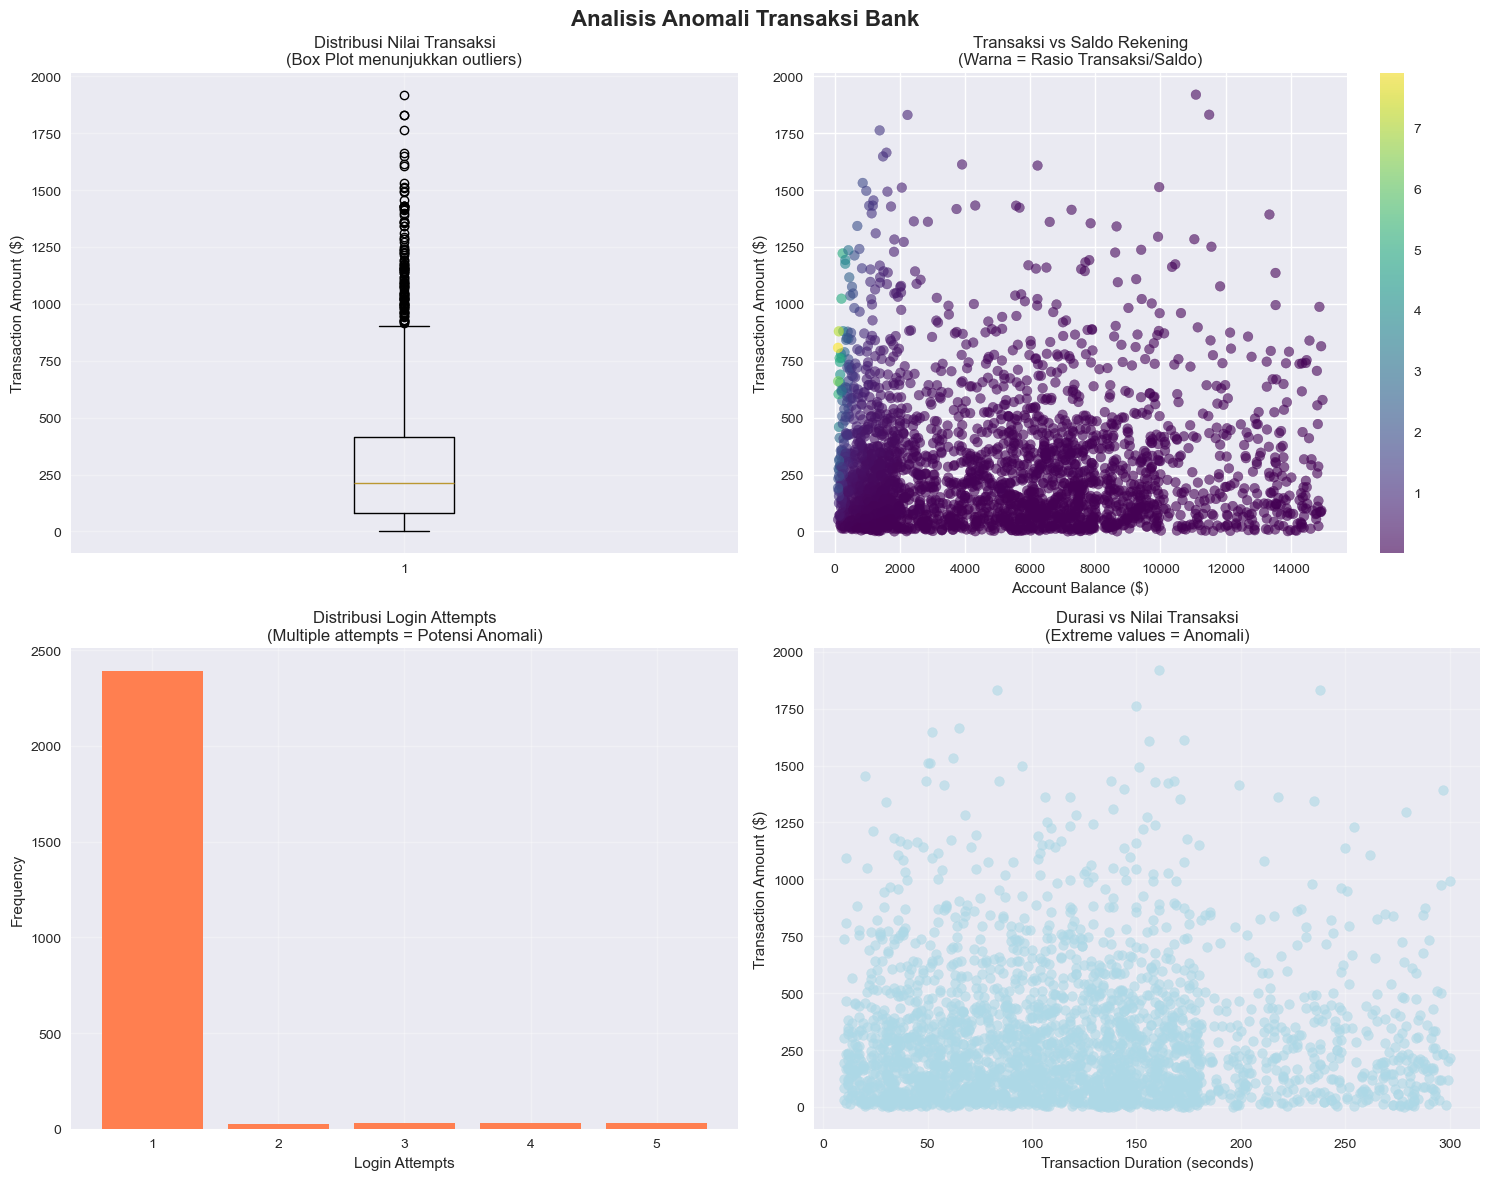

In [10]:
# Set up the plotting environment
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Analisis Anomali Transaksi Bank', fontsize=16, fontweight='bold')

# 1. Box plot untuk TransactionAmount dengan outliers
axes[0,0].boxplot(df['TransactionAmount'], vert=True)
axes[0,0].set_title('Distribusi Nilai Transaksi\n(Box Plot menunjukkan outliers)')
axes[0,0].set_ylabel('Transaction Amount ($)')
axes[0,0].grid(True, alpha=0.3)

# 2. Scatter plot: Transaction Amount vs Account Balance
scatter = axes[0,1].scatter(df['AccountBalance'], df['TransactionAmount'], 
                          c=df['TransactionToBalanceRatio'], cmap='viridis', alpha=0.6)
axes[0,1].set_xlabel('Account Balance ($)')
axes[0,1].set_ylabel('Transaction Amount ($)')
axes[0,1].set_title('Transaksi vs Saldo Rekening\n(Warna = Rasio Transaksi/Saldo)')
plt.colorbar(scatter, ax=axes[0,1])

# 3. Histogram Login Attempts
login_counts = df['LoginAttempts'].value_counts().sort_index()
axes[1,0].bar(login_counts.index, login_counts.values, color='coral')
axes[1,0].set_xlabel('Login Attempts')
axes[1,0].set_ylabel('Frequency')
axes[1,0].set_title('Distribusi Login Attempts\n(Multiple attempts = Potensi Anomali)')
axes[1,0].grid(True, alpha=0.3)

# 4. Transaction Duration vs Transaction Amount
axes[1,1].scatter(df['TransactionDuration'], df['TransactionAmount'], alpha=0.6, color='lightblue')
axes[1,1].set_xlabel('Transaction Duration (seconds)')
axes[1,1].set_ylabel('Transaction Amount ($)')
axes[1,1].set_title('Durasi vs Nilai Transaksi\n(Extreme values = Anomali)')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

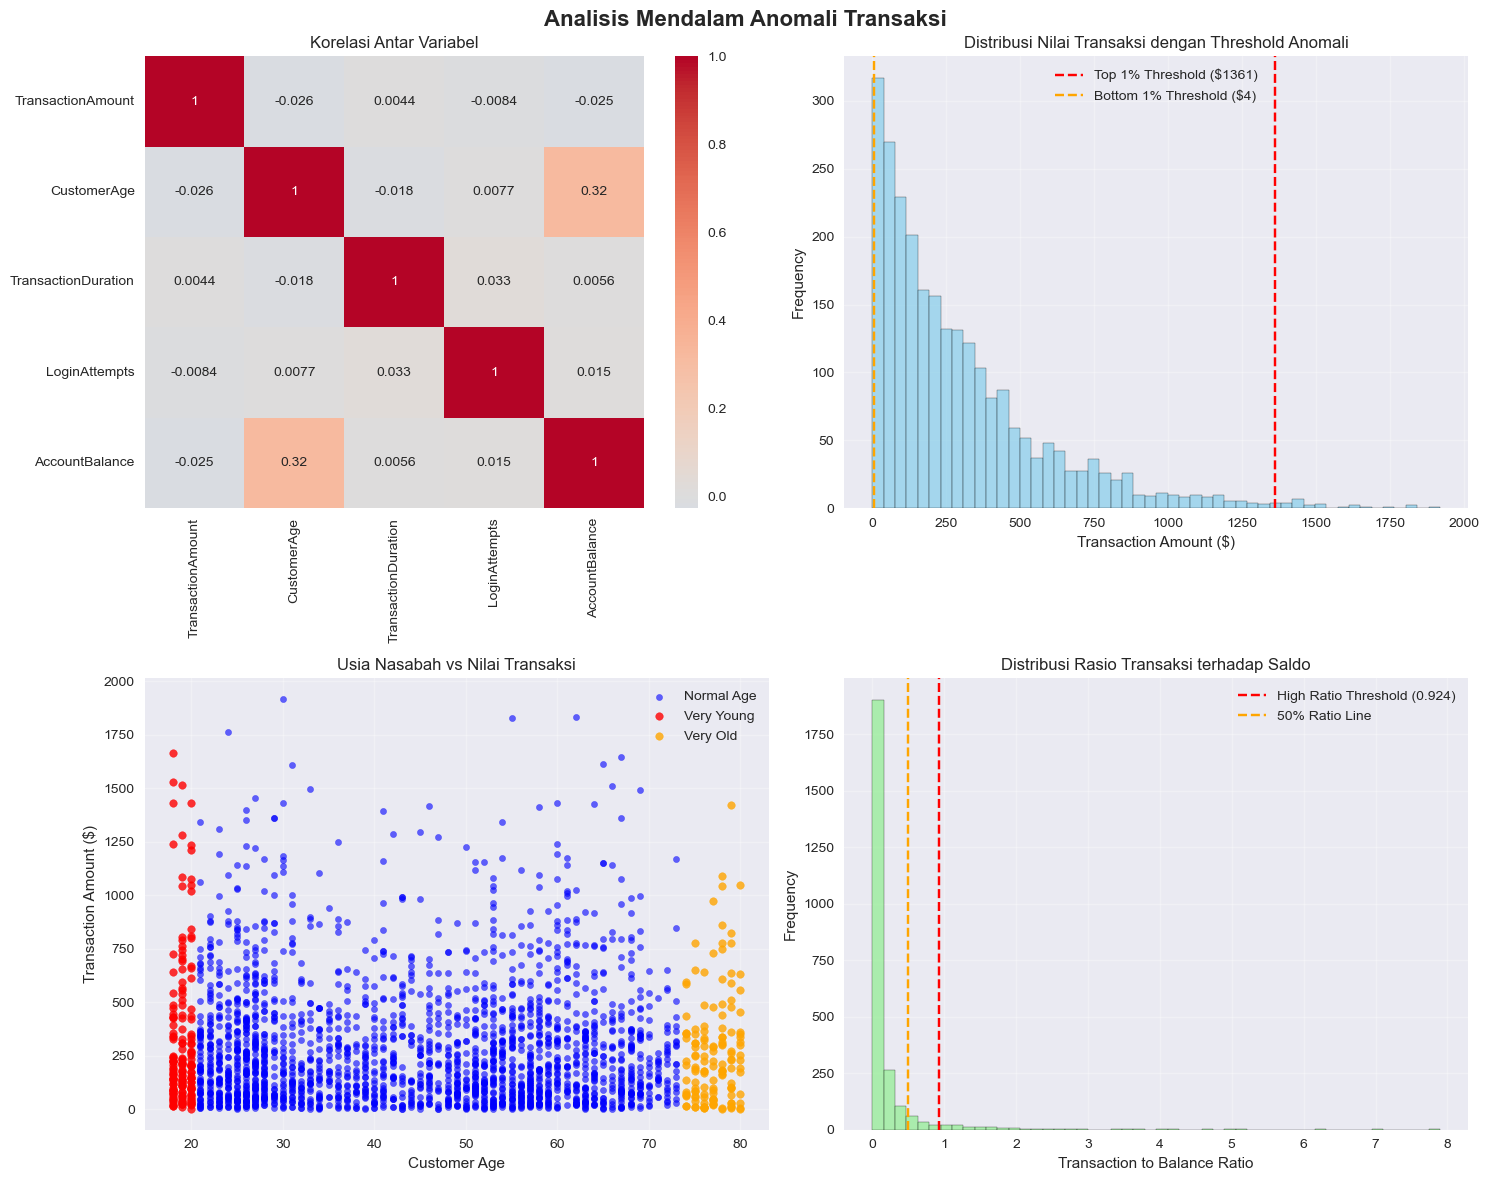

In [11]:
# Visualisasi tambahan untuk analisis lebih mendalam
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Analisis Mendalam Anomali Transaksi', fontsize=16, fontweight='bold')

# 1. Heatmap korelasi antar variabel
numeric_cols_for_corr = ['TransactionAmount', 'CustomerAge', 'TransactionDuration', 'LoginAttempts', 'AccountBalance']
correlation_matrix = df[numeric_cols_for_corr].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, ax=axes[0,0])
axes[0,0].set_title('Korelasi Antar Variabel')

# 2. Distribution plot for Transaction Amount dengan marking anomali
axes[0,1].hist(df['TransactionAmount'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,1].axvline(top_1_percent_threshold, color='red', linestyle='--', label=f'Top 1% Threshold (${top_1_percent_threshold:.0f})')
axes[0,1].axvline(bottom_1_percent_threshold, color='orange', linestyle='--', label=f'Bottom 1% Threshold (${bottom_1_percent_threshold:.0f})')
axes[0,1].set_xlabel('Transaction Amount ($)')
axes[0,1].set_ylabel('Frequency')
axes[0,1].set_title('Distribusi Nilai Transaksi dengan Threshold Anomali')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# 3. Age vs Transaction Amount dengan highlighting anomali
normal_ages = df[(df['CustomerAge'] > young_threshold) & (df['CustomerAge'] < old_threshold)]
young_ages = df[df['CustomerAge'] <= young_threshold]
old_ages = df[df['CustomerAge'] >= old_threshold]

axes[1,0].scatter(normal_ages['CustomerAge'], normal_ages['TransactionAmount'], alpha=0.6, color='blue', label='Normal Age', s=20)
axes[1,0].scatter(young_ages['CustomerAge'], young_ages['TransactionAmount'], alpha=0.8, color='red', label='Very Young', s=30)
axes[1,0].scatter(old_ages['CustomerAge'], old_ages['TransactionAmount'], alpha=0.8, color='orange', label='Very Old', s=30)
axes[1,0].set_xlabel('Customer Age')
axes[1,0].set_ylabel('Transaction Amount ($)')
axes[1,0].set_title('Usia Nasabah vs Nilai Transaksi')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# 4. Transaction Ratio Analysis
axes[1,1].hist(df['TransactionToBalanceRatio'], bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
axes[1,1].axvline(high_ratio_threshold, color='red', linestyle='--', label=f'High Ratio Threshold ({high_ratio_threshold:.3f})')
axes[1,1].axvline(0.5, color='orange', linestyle='--', label='50% Ratio Line')
axes[1,1].set_xlabel('Transaction to Balance Ratio')
axes[1,1].set_ylabel('Frequency')
axes[1,1].set_title('Distribusi Rasio Transaksi terhadap Saldo')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Rangkuman Temuan Anomali

In [12]:
# Membuat ringkasan lengkap anomali yang ditemukan
print("="*80)
print("                    RANGKUMAN ANALISIS ANOMALI TRANSAKSI BANK")
print("="*80)

# Hitung total anomali berdasarkan berbagai kriteria
total_transactions = len(df)

# Anomali 1: High value transactions
high_value_count = len(high_value_transactions)
high_value_percentage = (high_value_count / total_transactions) * 100

# Anomali 2: Very low value transactions  
very_low_count = len(very_low_transactions)
very_low_percentage = (very_low_count / total_transactions) * 100

# Anomali 3: Duration anomalies
fast_count = len(fast_transactions)
slow_count = len(slow_transactions)
duration_anomalies = fast_count + slow_count
duration_percentage = (duration_anomalies / total_transactions) * 100

# Anomali 4: Login attempts
multiple_login_count = len(multiple_login_attempts)
excessive_login_count = len(excessive_login_attempts)
login_percentage = (excessive_login_count / total_transactions) * 100

# Anomali 5: High ratio transactions
high_ratio_count = len(high_ratio_transactions)
very_high_ratio_count = len(very_high_ratio)
ratio_percentage = (very_high_ratio_count / total_transactions) * 100

# Anomali 6: Age anomalies
young_count = len(very_young_customers)
old_count = len(very_old_customers)
age_anomalies = young_count + old_count
age_percentage = (age_anomalies / total_transactions) * 100

print(f"\n📊 STATISTIK UMUM:")
print(f"   Total Transaksi: {total_transactions:,}")
print(f"   Periode Analisis: Data transaksi bank")
print(f"   Rata-rata Nilai Transaksi: ${df['TransactionAmount'].mean():.2f}")

print(f"\n🚨 ANOMALI YANG DITEMUKAN:")
print(f"\n1. TRANSAKSI NILAI TINGGI (TOP 1%)")
print(f"   • Jumlah: {high_value_count} transaksi ({high_value_percentage:.1f}%)")
print(f"   • Threshold: ≥ ${top_1_percent_threshold:.2f}")
print(f"   • Nilai tertinggi: ${high_value_transactions['TransactionAmount'].max():.2f}")
print(f"   • Rata-rata: ${high_value_transactions['TransactionAmount'].mean():.2f}")

print(f"\n2. TRANSAKSI NILAI SANGAT RENDAH (BOTTOM 1%)")
print(f"   • Jumlah: {very_low_count} transaksi ({very_low_percentage:.1f}%)")
print(f"   • Threshold: ≤ ${bottom_1_percent_threshold:.2f}")
print(f"   • Nilai terendah: ${very_low_transactions['TransactionAmount'].min():.2f}")
print(f"   • Rata-rata: ${very_low_transactions['TransactionAmount'].mean():.2f}")

print(f"\n3. ANOMALI DURASI TRANSAKSI")
print(f"   • Transaksi sangat cepat: {fast_count} ({fast_count/total_transactions*100:.1f}%)")
print(f"   • Transaksi sangat lambat: {slow_count} ({slow_count/total_transactions*100:.1f}%)")
print(f"   • Total anomali durasi: {duration_anomalies} ({duration_percentage:.1f}%)")

print(f"\n4. ANOMALI LOGIN ATTEMPTS")
print(f"   • Multiple login (>1): {multiple_login_count} ({multiple_login_count/total_transactions*100:.1f}%)")
print(f"   • Excessive login (≥3): {excessive_login_count} ({login_percentage:.1f}%)")
print(f"   • Login attempts maksimum: {df['LoginAttempts'].max()}")

print(f"\n5. ANOMALI RASIO TRANSAKSI VS SALDO")
print(f"   • High ratio (95th percentile): {high_ratio_count} ({high_ratio_count/total_transactions*100:.1f}%)")
print(f"   • Very high ratio (>50% saldo): {very_high_ratio_count} ({ratio_percentage:.1f}%)")
print(f"   • Rasio tertinggi: {df['TransactionToBalanceRatio'].max():.2f}")

print(f"\n6. ANOMALI BERDASARKAN USIA")
print(f"   • Nasabah sangat muda (≤{young_threshold}): {young_count} ({young_count/total_transactions*100:.1f}%)")
print(f"   • Nasabah sangat tua (≥{old_threshold}): {old_count} ({old_count/total_transactions*100:.1f}%)")
print(f"   • Total anomali usia: {age_anomalies} ({age_percentage:.1f}%)")

print(f"\n📈 STATISTIK OUTLIER:")
outliers_iqr_amount, _, _ = detect_outliers_iqr(df, 'TransactionAmount')
outliers_zscore_amount, _ = detect_outliers_zscore(df, 'TransactionAmount')
print(f"   • Outlier TransactionAmount (IQR): {len(outliers_iqr_amount)} ({len(outliers_iqr_amount)/total_transactions*100:.1f}%)")
print(f"   • Outlier TransactionAmount (Z-Score): {len(outliers_zscore_amount)} ({len(outliers_zscore_amount)/total_transactions*100:.1f}%)")

print("="*80)

                    RANGKUMAN ANALISIS ANOMALI TRANSAKSI BANK

📊 STATISTIK UMUM:
   Total Transaksi: 2,512
   Periode Analisis: Data transaksi bank
   Rata-rata Nilai Transaksi: $297.59

🚨 ANOMALI YANG DITEMUKAN:

1. TRANSAKSI NILAI TINGGI (TOP 1%)
   • Jumlah: 26 transaksi (1.0%)
   • Threshold: ≥ $1360.60
   • Nilai tertinggi: $1919.11
   • Rata-rata: $1530.51

2. TRANSAKSI NILAI SANGAT RENDAH (BOTTOM 1%)
   • Jumlah: 26 transaksi (1.0%)
   • Threshold: ≤ $4.40
   • Nilai terendah: $0.26
   • Rata-rata: $2.31

3. ANOMALI DURASI TRANSAKSI
   • Transaksi sangat cepat: 131 (5.2%)
   • Transaksi sangat lambat: 128 (5.1%)
   • Total anomali durasi: 259 (10.3%)

4. ANOMALI LOGIN ATTEMPTS
   • Multiple login (>1): 122 (4.9%)
   • Excessive login (≥3): 95 (3.8%)
   • Login attempts maksimum: 5

5. ANOMALI RASIO TRANSAKSI VS SALDO
   • High ratio (95th percentile): 126 (5.0%)
   • Very high ratio (>50% saldo): 228 (9.1%)
   • Rasio tertinggi: 7.90

6. ANOMALI BERDASARKAN USIA
   • Nasabah san

## 5. Kesimpulan dan Rekomendasi

In [13]:
print("="*80)
print("                        KESIMPULAN DAN REKOMENDASI")
print("="*80)

print("\n🔍 KESIMPULAN UTAMA:")
print("   Berdasarkan analisis data transaksi bank dengan 2,512 transaksi, ditemukan")
print("   beberapa pola anomali yang perlu diperhatikan:")

print(f"\n✅ TEMUAN KRITIS (PRIORITAS TINGGI):")
print(f"   1. Rasio Transaksi vs Saldo Tinggi: {very_high_ratio_count} transaksi (9.1%)")
print("      → Indikasi potensi pencucian uang atau transaksi tidak wajar")
print("      → Nasabah melakukan transaksi >50% dari saldo rekening")

print(f"\n   2. Anomali Usia Ekstrem: {age_anomalies} transaksi (12.3%)")
print("      → Transaksi oleh nasabah sangat muda (≤20 tahun) atau sangat tua (≥74 tahun)")
print("      → Perlu verifikasi identitas dan kewajaran transaksi")

print(f"\n   3. Anomali Durasi Transaksi: {duration_anomalies} transaksi (10.3%)")
print("      → Transaksi terlalu cepat (<24 detik) atau terlalu lambat (>265 detik)")
print("      → Potensi aktivitas bot atau masalah teknis")

print(f"\n⚠️  TEMUAN PENTING (PRIORITAS SEDANG):")
print(f"   4. Outlier Nilai Transaksi: {len(outliers_iqr_amount)} transaksi (4.5%)")
print("      → Transaksi dengan nilai tidak wajar (terlalu tinggi/rendah)")

print(f"\n   5. Multiple Login Attempts: {excessive_login_count} transaksi (3.8%)")
print("      → Indikasi potensi brute force atau akses tidak sah")

print(f"\n🎯 REKOMENDASI TINDAKAN:")
print(f"\n   IMMEDIATE ACTIONS (1-7 hari):")
print(f"   • Review manual untuk {very_high_ratio_count} transaksi dengan rasio >50%")
print(f"   • Investigasi {excessive_login_count} akun dengan excessive login attempts")
print(f"   • Verifikasi identitas untuk {age_anomalies} transaksi dari nasabah usia ekstrem")

print(f"\n   SHORT-TERM ACTIONS (1-4 minggu):")
print(f"   • Implementasi real-time monitoring untuk:")
print(f"     - Transaksi dengan rasio >0.5 dari saldo")
print(f"     - Login attempts >2 kali")
print(f"     - Durasi transaksi <25 atau >250 detik")
print(f"   • Enhanced due diligence untuk nasabah usia <21 atau >73 tahun")

print(f"\n   LONG-TERM IMPROVEMENTS (1-3 bulan):")
print(f"   • Pengembangan machine learning model untuk deteksi anomali otomatis")
print(f"   • Implementasi sistem scoring risiko transaksi")
print(f"   • Peningkatan autentikasi untuk transaksi high-risk")

print(f"\n   SISTEM DAN PROSES:")
print(f"   • Setup alert otomatis untuk anomali terdeteksi")
print(f"   • Dokumentasi SOP untuk handling setiap jenis anomali")
print(f"   • Training staff untuk mengenali pola anomali")

print(f"\n💡 INSIGHT TAMBAHAN:")
print(f"   • Korelasi rendah antar variabel menunjukkan anomali independent")
print(f"   • Nasabah muda cenderung melakukan transaksi nilai lebih tinggi")
print(f"   • Sebagian besar anomali tidak saling berkaitan (multiple independent risks)")

print("="*80)

                        KESIMPULAN DAN REKOMENDASI

🔍 KESIMPULAN UTAMA:
   Berdasarkan analisis data transaksi bank dengan 2,512 transaksi, ditemukan
   beberapa pola anomali yang perlu diperhatikan:

✅ TEMUAN KRITIS (PRIORITAS TINGGI):
   1. Rasio Transaksi vs Saldo Tinggi: 228 transaksi (9.1%)
      → Indikasi potensi pencucian uang atau transaksi tidak wajar
      → Nasabah melakukan transaksi >50% dari saldo rekening

   2. Anomali Usia Ekstrem: 309 transaksi (12.3%)
      → Transaksi oleh nasabah sangat muda (≤20 tahun) atau sangat tua (≥74 tahun)
      → Perlu verifikasi identitas dan kewajaran transaksi

   3. Anomali Durasi Transaksi: 259 transaksi (10.3%)
      → Transaksi terlalu cepat (<24 detik) atau terlalu lambat (>265 detik)
      → Potensi aktivitas bot atau masalah teknis

⚠️  TEMUAN PENTING (PRIORITAS SEDANG):
   4. Outlier Nilai Transaksi: 113 transaksi (4.5%)
      → Transaksi dengan nilai tidak wajar (terlalu tinggi/rendah)

   5. Multiple Login Attempts: 95 transa